# Binary Classification of a Structure Using Support Vector Machines
## Data Obtained from Neuropixels Probes

In [434]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%pprint
import warnings
import itertools as it
from sklearn.svm import SVC
from sklearn.preprocessing import scale
import seaborn as sns
sns.set()
sns.set_context('talk')
warnings.filterwarnings('ignore')

import braintv_ephys_dev.workstation.danield.utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pretty printing has been turned ON


# ETC Functions

In [234]:
def shuffle_data(features, targets):
    if features.shape[0] != targets.shape[0]:
        raise Exception('arguments not equal length')
        
    shuffle_array = np.array([[np.random.rand()] for i in range(features.shape[0])])
    shuffled_lists = sorted(zip(features, targets, shuffle_array), key=lambda x: x[2])
    features, targets, shuffled_array = [[x[i] for x in shuffled_lists] for i in range(3)]
    return np.array(features), np.array(targets)

In [486]:
def log_transform_features(features, transform_columns='all'):
    transformed_features = np.zeros(features.shape)
    
    if transform_columns == 'all':
        transform_columns = range(features.shape[1])
    
    for column in range(features.shape[1]):
        if column in transform_columns:
            if np.amin(features[:,column]) <= 0.0:
                transformed_features[:,column] = np.log1p(features[:,column] + abs(np.amin(features[:,column])))
            else:
                transformed_features[:,column] = np.log(features[:,column])
        else:
            transformed_features[:,column] = features[:,column]
        
    return transformed_features

## Structure to Test

In [487]:
struct = 'above'

# Prep Training Data

In [504]:
## Pull data from file
training_data = pd.read_csv('chunked_banded_data.csv')
training_features = training_data.drop(['targets'],axis=1).as_matrix()
training_targets = training_data.as_matrix(columns=['targets'])
print(training_features.shape)
print(training_targets.shape)

## Convert targets into only two classes
training_less_targets = np.empty((0,1))
for target in training_targets[:,0]:
    if struct.lower() in target.lower():
        training_less_targets = np.append(training_less_targets, [[struct]], axis=0)
    else:
        training_less_targets = np.append(training_less_targets, [['other']], axis=0)

(60L, 10L)
(60L, 1L)


In [505]:
## Normalize data to zero mean unit variance
norm_training_features = log_transform_features(scale(training_features), [0,1,2,3,4,5,6,7,8])

# Prep Testing Data

In [506]:
## Pull data from file
testing_data = pd.read_csv('not_chunked_banded_data.csv')
testing_features = testing_data.drop(['targets'],axis=1).as_matrix()
testing_targets = testing_data.as_matrix(columns=['targets'])
print(testing_features.shape)
print(testing_targets.shape)

## Convert targets into only two classes
testing_less_targets = np.empty((0,1))
for target in testing_targets[:,0]:
    if struct.lower() in target.lower():
        testing_less_targets = np.append(testing_less_targets, [[struct]], axis=0)
    else:
        testing_less_targets = np.append(testing_less_targets, [['other']], axis=0)

(3366L, 10L)
(3366L, 1L)


In [507]:
## Normalize data to zero mean unit variance
norm_testing_features =log_transform_features(scale(testing_features), [0,1,2,3,4,5,6,7,8])

# Calculate weights for SVM based on how often the target occurs

In [508]:
num_struct = len(np.where(testing_less_targets == [[struct]])[0])
num_other = len(np.where(testing_less_targets == [['other']])[0])
total_tests = len(testing_less_targets)

target_weights = {'other': total_tests / float(num_other),
                  struct: total_tests / float(num_struct)}

In [509]:
target_weights

{'above': 10.108108108108109, 'other': 1.1097922848664687}

# Put data into more general variables to use in the SVM

In [510]:
train_x, train_y = shuffle_data(norm_training_features, training_less_targets)
test_x = norm_testing_features
test_y = testing_less_targets

In [511]:
print train_x.shape
print train_y.shape
print test_x.shape
print test_y.shape

(60L, 10L)
(60L, 1L)
(3366L, 10L)
(3366L, 1L)


# Making SVM

In [524]:
## Function to run svm and all normalization in one call
def make_prediction_svm(train_x, train_y, test_x, struct, target_weights):
    predictions_total = np.zeros((1, len(test_x)))
    predictions_norm = np.zeros(predictions_total.shape)
    
    # Run the model various times in case C or gamma need to be tuned
    for k in range(1):
        svc = SVC(C=25.0, 
                  kernel='rbf', 
                  degree=2,
                  gamma= 1.0 / 1, 
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.0001, 
                  cache_size=200, 
                  class_weight=target_weights, 
                  verbose=False, 
                  max_iter=-1, 
                  decision_function_shape='ovr', 
                  random_state=None)
        
        svc.fit(train_x, train_y)
        predictions = svc.predict(test_x)
                
        # Summing predictions if many trails done
        for j, prediction in enumerate(predictions):
            if prediction == struct:
                predictions_total[0, j] += 1
        
    
    ## Normalizing predictions
    ## 374 is hardcoded as that's the number of channels on the probe
    for i in range(predictions_total.shape[1] / 374):
        predictions_norm[0, 0 + 374 * i:374 + 374 * i] = predictions_total[0, 0 + 374 * i:374 + 374 * i] \
                                                         / max(np.amax(predictions_total[0, 0 + 374 * i:374 + 374 * i]), 1)

    ## Round predictions to 0 or 1 (other or struct)
    predictions_norm = np.around(predictions_norm - 0.0)
    
    return predictions_norm

In [525]:
predictions = make_prediction_svm(train_x, train_y, test_x, struct, target_weights)

## Plot Results (hard coded to work with how the test data in this case was set up)

In [526]:
test_y_binary = []
for structure in test_y[:,0]:
    if structure == struct:
        test_y_binary.append(1)
    else:
        test_y_binary.append(0)

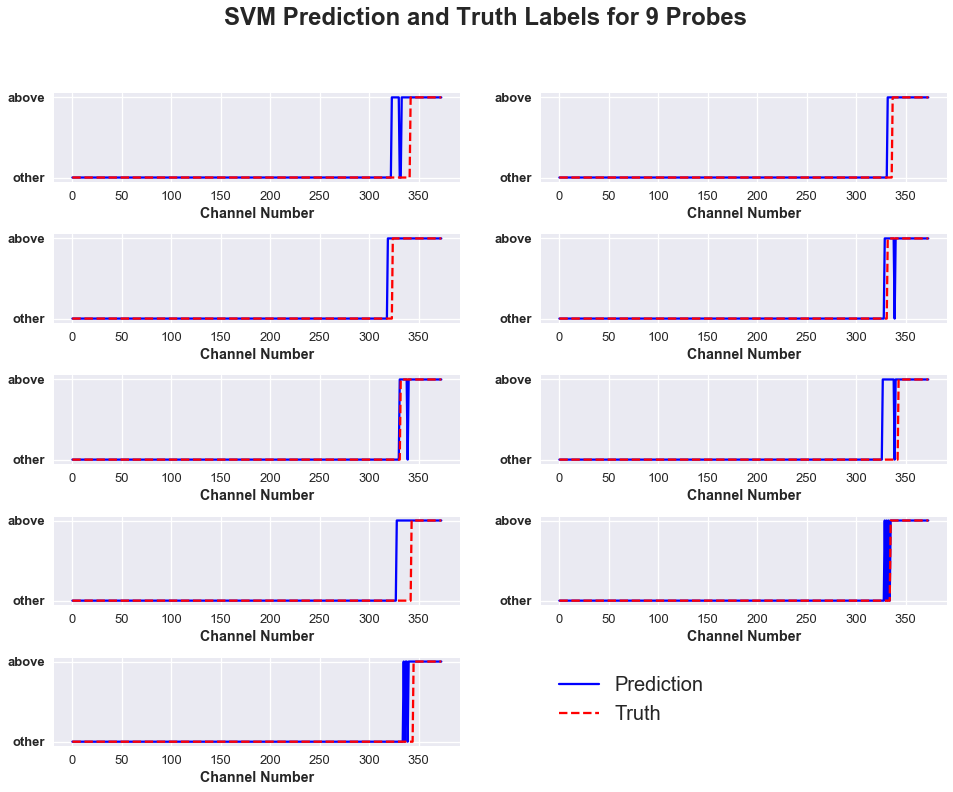

In [527]:
fig = plt.figure(figsize=(16,12))
plt.suptitle('SVM Prediction and Truth Labels for 9 Probes', fontsize=24, fontweight='bold')
for i in range(9):
    plt.subplot(5,2,i + 1)
    plt.subplots_adjust(hspace=.6)
    
    prediction_line = plt.plot(predictions[0, 0 + 374 * i:374 + 374 * i], 'b-', label='Prediction');
    truth_line = plt.plot(test_y_binary[0 + 374 * i:374 + 374 * i], 'r--', label='Truth')
    
    plt.xlabel('Channel Number', fontweight='bold')
    plt.yticks(range(2), ['other', '\n'.join(struct.split())], fontweight='bold')

f = plt.subplot(5,2,10)
prediction_line = plt.plot([0], 'b-', label='Prediction');
truth_line = plt.plot([0], 'r--', label='Truth')
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor('white')
plt.legend(loc='upper left', fontsize=20);
